# Vehicle Detection Project


The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
- Optionally, you apply color transform and append binned color features, to HOG feature vector.
- Train a classifier to disinguish between car and non-car images
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run vehicle detection pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


In [62]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lane_detection import process_image_vid as draw_lane_lines
import os
from moviepy.editor import VideoFileClip
import pickle
import time
import random
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Load Training Data

In [20]:
notcars = glob.glob('data/non-vehicles/**/*.png')
cars = glob.glob('data/vehicles/**/*.png')

print("Number of cars: ", len(cars), "Number of no-cars: ", len(notcars))


Number of cars:  8792 Number of no-cars:  8968


### Visualize Some Data

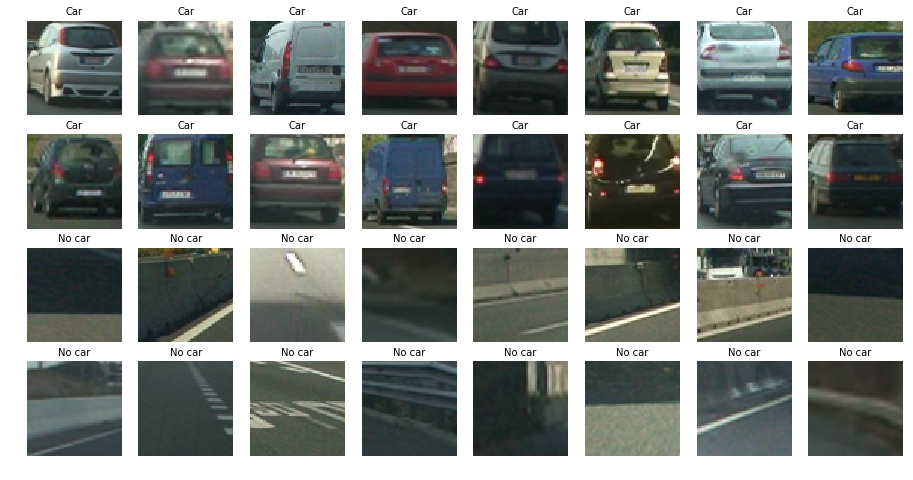

In [10]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('No car', fontsize=10)
    axs[i].imshow(img)

### Auxiliary functions

In [13]:
# Function to convert between color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Get hot features of image 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features


# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


## Histogram of Oriented Gradients (HOG)

(-0.5, 63.5, 63.5, -0.5)

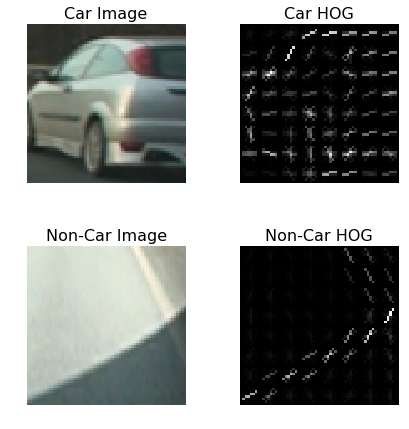

In [18]:
car_img = mpimg.imread(cars[2])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = mpimg.imread(notcars[2])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax1.axis('off')
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax2.axis('off')
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax3.axis('off')
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
ax4.axis('off')


In [39]:
class Params:
    def __init__(self, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                 spatial_size=(32,32), hist_bins=32, spatial_feat=True, hist_feat=True, hog_feat=True, rand_state=None):
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.rand_state = rand_state

    def __str__(self):
        return str("color_space: " + self.color_space +  ", orient: " + str(self.orient) +  ", pix_per_cell: " + str(self.pix_per_cell) + ", cell_per_block: " + str(self.cell_per_block) + ", hog_channel: " + str(self.hog_channel) + \
               ", spatial_size: " + str(self.spatial_size) + ", hist_bins: " + str(self.hist_bins) + ", spatial_feat: " + str(self.spatial_feat) + ", hist_feat: " + str(self.hist_feat) + ", hog_feat :" + str(self.hog_feat) + ", rand_state: " + str(self.rand_state))


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

def train(params, cars_img, notcars_img):
    car_features = extract_features(cars_img, color_space=params.color_space,
                                    spatial_size=params.spatial_size, hist_bins=params.hist_bins,
                                    orient=params.orient, pix_per_cell=params.pix_per_cell,
                                    cell_per_block=params.cell_per_block,
                                    hog_channel=params.hog_channel, spatial_feat=params.spatial_feat,
                                    hist_feat=params.hist_feat, hog_feat=params.hog_feat)
    notcar_features = extract_features(notcars_img, color_space=params.color_space,
                                       spatial_size=params.spatial_size, hist_bins=params.hist_bins,
                                       orient=params.orient, pix_per_cell=params.pix_per_cell,
                                       cell_per_block=params.cell_per_block,
                                       hog_channel=params.hog_channel, spatial_feat=params.spatial_feat,
                                       hist_feat=params.hist_feat, hog_feat=params.hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    if params.rand_state is None:
        rand_state = np.random.randint(0, 100)
    else:
        rand_state = params.rand_state

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    svc.fit(X_train, y_train)

    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    # Check the prediction time for a single sample
    return X_scaler, svc, accuracy


### Tunning HOG parameters

Create a generator to test 100 random configurations based on a list of possible values. 

Showing only the first 25.

In [43]:
notcars_sub = notcars[0:2000]
cars_sub = cars[0:2000]

def param_generator():
    color_space_values = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb' ]
    orient_values = [5, 7, 9, 12, 14]
    pix_per_cell_values = [6, 7, 8, 9, 10]
    cell_per_block_values = [2, 3, 4]
    hog_channel_values = [0, 1, 2, 'ALL']
    spatial_size_values = [(16,16), (24, 24), (32, 32), (40, 40), (48, 48)]
    hist_bins_values = [24, 28, 32, 36, 40, 48]
    spatial_feat_values = True
    hist_feat_values = True
    hog_feat_values = True
    rand_state = 41

    param = Params(random.choice(color_space_values), random.choice(orient_values), random.choice(pix_per_cell_values),
                      random.choice(cell_per_block_values), random.choice(hog_channel_values), random.choice(spatial_size_values),
                      random.choice(hist_bins_values), spatial_feat_values, hist_feat_values,
                      hog_feat_values, rand_state)

    return param


class LinearSVC_Exec:
    def __init__(self):
        self.param = param_generator()
        self.time = 0
        self.accuracy = 0

    def test_params(self):
        t=time.time()
        _, _, self.accuracy = train(self.param, cars_sub, notcars_sub)
        t2 = time.time()
        self.time = round(t2-t, 2)

    def get_pd(self):
        return {'color_space': self.param.color_space, 'orient': self.param.orient, 'pix_per_cell' : self.param.pix_per_cell,
                'cell_per_block' : self.param.cell_per_block, 'hog_channel': self.param.hog_channel,
                'spatial_size' : self.param.spatial_size, 'hist_bins': self.param.hist_bins, 'time' : self.time, 'accuracy': self.accuracy }

    def __str__(self):
        return str(str(self.param) + ", time: " + str(self.time) + ", accuracy: " + str(self.accuracy))

def tune_params(population):
    lsvc_hog_params = 'lsvc_hog_params.csv'
    if os.path.exists(lsvc_hog_params):
        return pd.read_csv(lsvc_hog_params)
    
    list_sols = pd.DataFrame([], columns=['color_space', 'orient', 'pix_per_cell', 'cell_per_block', 'hog_channel',
                                          'spatial_size', 'hist_bins', 'time', 'accuracy'])
    for p in range(population):
        try:
            lsvc_exec = LinearSVC_Exec()
            lsvc_exec.test_params()
            list_sols = list_sols.append(lsvc_exec.get_pd(), ignore_index=True)
        except:
            continue

    list_sols.sort_values('accuracy', inplace=True, ascending=False)
    list_sols.to_csv(lsvc_hog_params)

    return list_sols

params_list = tune_params(100)


In [47]:
params_list[['color_space', 'orient', 'pix_per_cell', 
                'cell_per_block', 'hog_channel', 'spatial_size', 'hist_bins', 'time', 'accuracy']][0:20]

,color_space,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,time,accuracy
0,YCrCb,7.0,8.0,2.0,ALL,"(32, 32)",36.0,12.84,1.0000
1,YCrCb,9.0,8.0,3.0,ALL,"(16, 16)",48.0,12.65,0.9975
2,YUV,9.0,8.0,4.0,ALL,"(48, 48)",24.0,14.04,0.9975
3,HSV,9.0,6.0,3.0,ALL,"(24, 24)",28.0,14.65,0.9975
4,YCrCb,12.0,9.0,4.0,ALL,"(24, 24)",32.0,11.02,0.9950
5,HSV,12.0,10.0,2.0,ALL,"(16, 16)",24.0,9.39,0.9950
6,HSV,14.0,6.0,3.0,2,"(24, 24)",36.0,7.22,0.9950
7,YCrCb,5.0,9.0,4.0,ALL,"(24, 24)",48.0,10.86,0.9950
8,YUV,5.0,8.0,3.0,ALL,"(32, 32)",32.0,12.74,0.9950
9,HLS,14.0,7.0,3.0,1,"(48, 48)",48.0,7.55,0.9925


## Final HOG Parameters

- Always use the three types of features activating the flags spatial_feat_values, hist_feat_values,hog_feat_values. I dit not include the flags in the table because the results where bad without one or two of the features. (i did some previous calculation)
- Is clear that is useful to use **ALL** for the channels of the HOG.
- For the **color space** there is a tendency to use the **YCrCb, or RGB**.
- For the **orient** variable is seems to be better to use a higher value than the default, something around **12**
- A higger value on the numbers of bins seems to work better, set to **48**.
- The pix_per_cell, cell_per_block and the spatial_size seems to work well with the default values.

```python
params = Params(color_space='YCrCb', 
                orient=12, pix_per_cell=8, 
                cell_per_block=2, 
                hog_channel='ALL',
                spatial_size=(32,32), 
                hist_bins=48, 
                spatial_feat=True, 
                hist_feat=True, 
                hog_feat=True)
```


### Model Accuracy

In [66]:
params = Params(color_space='YCrCb', orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', 
                spatial_size=(32,32), hist_bins=48,spatial_feat=True, hist_feat=True, hog_feat=True)

car_features = extract_features(cars, color_space=params.color_space,
                                spatial_size=params.spatial_size, hist_bins=params.hist_bins,
                                orient=params.orient, pix_per_cell=params.pix_per_cell,
                                cell_per_block=params.cell_per_block,
                                hog_channel=params.hog_channel, spatial_feat=params.spatial_feat,
                                hist_feat=params.hist_feat, hog_feat=params.hog_feat)
notcar_features = extract_features(notcars, color_space=params.color_space,
                                   spatial_size=params.spatial_size, hist_bins=params.hist_bins,
                                   orient=params.orient, pix_per_cell=params.pix_per_cell,
                                   cell_per_block=params.cell_per_block,
                                   hog_channel=params.hog_channel, spatial_feat=params.spatial_feat,
                                   hist_feat=params.hist_feat, hog_feat=params.hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc_model_file = 'svc_pickle.p'
if os.path.exists(svc_model_file):
    dist_pickle = pickle.load(open(svc_model_file, "rb"))
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
else:
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    with open(svc_model_file, 'wb') as handle:
        pickle.dump({"svc": svc, "scaler": X_scaler}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
print("Accuracy : ", accuracy)

Accuracy :  0.9927


# Sliding Window Search

In [52]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_boxes=False):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if draw_all_boxes:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bbox_list.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (255, 0, 0), 6)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bbox_list.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img, bbox_list

### Windows Parameters

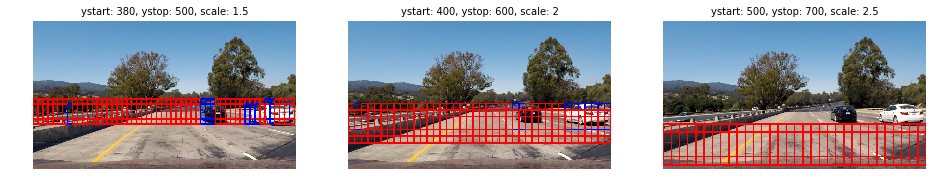

In [73]:
test_image = mpimg.imread('test_images/test1.jpg')

ystart = 380
ystop = 500
scale = 1.5

box_img1, _ = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, 
                              params.orient, params.pix_per_cell, params.cell_per_block, 
                              params.spatial_size, params.hist_bins, True)

ystart = 400
ystop = 600
scale = 2

box_img2, _ = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, 
                              params.orient, params.pix_per_cell, params.cell_per_block, 
                              params.spatial_size, params.hist_bins, True)

ystart = 500
ystop = 700
scale = 2.5

box_img3, _ = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, 
                              params.orient, params.pix_per_cell, params.cell_per_block, 
                              params.spatial_size, params.hist_bins, True)


fig, axs = plt.subplots(1,3, figsize=(16, 8))
#fig.subplots_adjust(hspace = .2, wspace=.001)

axs[0].axis('off')
axs[0].set_title('ystart: 380, ystop: 500, scale: 1.5', fontsize=10)
axs[0].imshow(box_img1)

axs[1].axis('off')
axs[1].set_title('ystart: 400, ystop: 600, scale: 2', fontsize=10)
axs[1].imshow(box_img2)

axs[2].axis('off')
axs[2].set_title('ystart: 500, ystop: 700, scale: 2.5', fontsize=10)
axs[2].imshow(box_img3)

plt.show()

### HeatMap and Label Detection

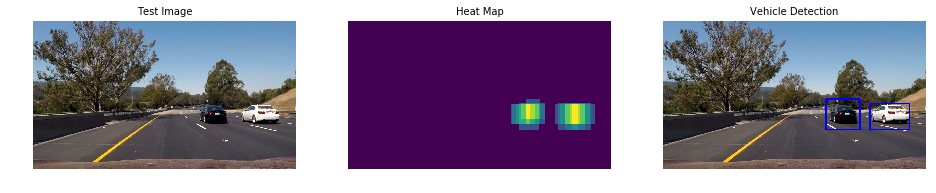

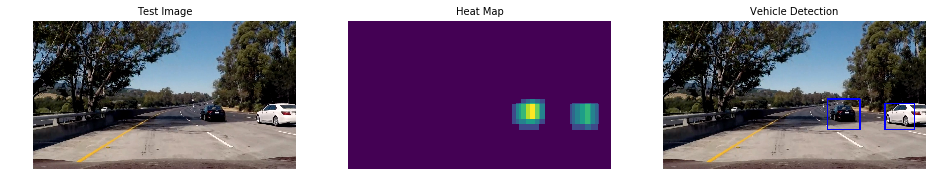

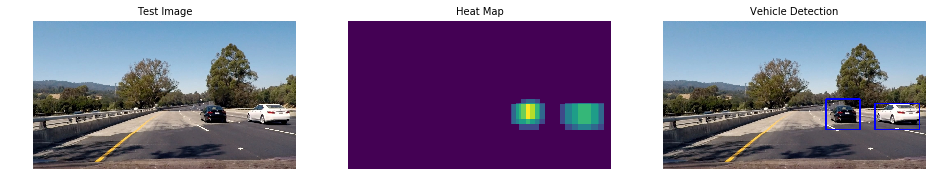

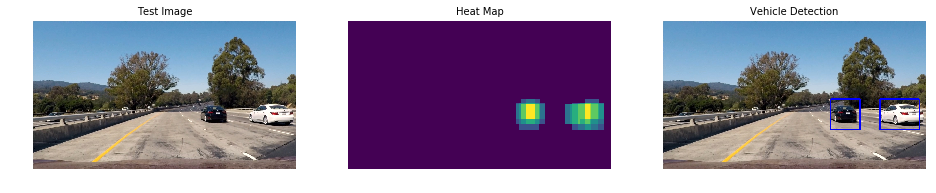

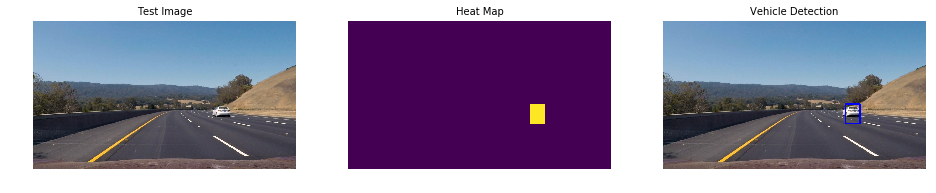

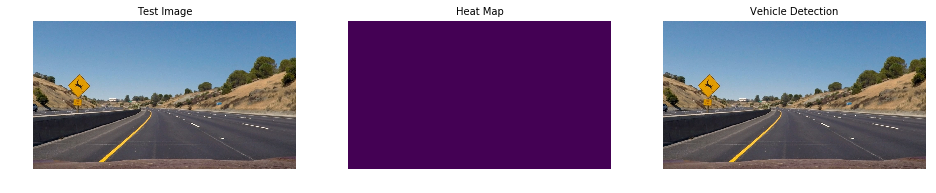

In [82]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def draw_real_boxes(image, box_list):
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img, heatmap

def get_all_boxes(svc, X_scaler, image):
    bboxes_list = []
    
    _, box_list = find_cars(image, 380, 500, 1.5, svc, X_scaler, params.orient, params.pix_per_cell, params.cell_per_block, params.spatial_size, params.hist_bins)
    bboxes_list.extend(box_list)

    _, box_list = find_cars(image, 400, 600, 2, svc, X_scaler, params.orient, params.pix_per_cell, params.cell_per_block, params.spatial_size, params.hist_bins)
    bboxes_list.extend(box_list)

    _, box_list = find_cars(image, 500, 700, 2.5, svc, X_scaler, params.orient, params.pix_per_cell, params.cell_per_block, params.spatial_size, params.hist_bins)
    bboxes_list.extend(box_list)
    
    return bboxes_list


def draw_test_images(image):

    bboxes_list = get_all_boxes(svc, X_scaler, image)
    box_img, heatmap = draw_real_boxes(image, bboxes_list)

    fig, axs = plt.subplots(1,3, figsize=(16, 8))
    #fig.subplots_adjust(hspace = .2, wspace=.001)

    axs[0].axis('off')
    axs[0].set_title('Test Image', fontsize=10)
    axs[0].imshow(image)

    axs[1].axis('off')
    axs[1].set_title('Heat Map', fontsize=10)
    axs[1].imshow(heatmap)

    axs[2].axis('off')
    axs[2].set_title('Vehicle Detection', fontsize=10)
    axs[2].imshow(box_img)
    plt.show()


test_images = glob.glob('test_images/*.jpg')
for fimg in test_images:
    image =  mpimg.imread(fimg)
    draw_test_images(image)
    


# Video

In [87]:

def image_process(image):

    bboxes_list = get_all_boxes(svc, X_scaler, image)
    box_img, heatmap = draw_real_boxes(image, bboxes_list)
    
    heatmap = np.dstack((heatmap, heatmap, heatmap))*255

    box_img_scaled = cv2.resize(box_img, (0,0), fx=0.5, fy=0.5)
    heatmap_scaled = cv2.resize(heatmap, (0,0), fx=0.5, fy=0.5)

    final = np.zeros((int(image.shape[0]/2), int(image.shape[1]), 3), dtype=np.uint8)
    final[:,0:int(final.shape[1]/2)] = box_img_scaled
    final[:,int(final.shape[1]/2):final.shape[1]] = heatmap_scaled
    

    return final

def process_video(video, video_output):
    """ Process frames of video using the process image function to draw lane lines"""
    frame_counter = 0
    clip1 = VideoFileClip(video)
    #t=time.time()
    clip = clip1.fl_image(image_process)
    clip.write_videofile(video_output, audio=False, verbose=False, progress_bar=False)
    #t2 = time.time()
    #print(round(t2-t, 2)/frame_counter)


#process_video('test_video.mp4', 'output_videos/test_video.mp4')
process_video('project_video.mp4', 'output_videos/project_video.mp4')
    